In [1]:
import numpy as np
import pandas as pd
import pickle
import gpflow
import matplotlib.pyplot as plt
import time

W0815 13:45:01.813680 139952925374272 deprecation_wrapper.py:119] From /home/rui/anaconda3/lib/python3.7/site-packages/gpflow/session_manager.py:31: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0815 13:45:01.814792 139952925374272 deprecation_wrapper.py:119] From /home/rui/anaconda3/lib/python3.7/site-packages/gpflow/misc.py:27: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0815 13:45:01.886119 139952925374272 deprecation_wrapper.py:119] From /home/rui/anaconda3/lib/python3.7/site-packages/gpflow/training/tensorflow_optimizer.py:169: The name tf.train.AdadeltaOptimizer is deprecated. Please use tf.compat.v1.train.AdadeltaOptimizer instead.

W0815 13:45:01.886673 139952925374272 deprecation_wrapper.py:119] From /home/rui/anaconda3/lib/python3.7/site-packages/gpflow/training/tensorflow_optimizer.py:156: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0815 13:45:01.887116 139

In [2]:
# Load data
with open("../data/flight8k.pickle", "rb") as res:
    df_train, df_test = pickle.load(res)
X_train = df_train.iloc[:, :-1].values
Y_train = df_train.iloc[:, -1].values
X_test = df_test.iloc[:, :-1].values
Y_test = df_test.iloc[:, -1].values

In [3]:
print(X_train.shape, Y_train.shape)

(7000, 8) (7000,)


In [4]:
# Inference using SVI
M = 100
D = 8
def init():
    kern = gpflow.kernels.RBF(D, 1, ARD=True)
    Z = X_train[:M, :].copy()
    m = gpflow.models.SVGP(X_train, Y_train.reshape([-1,1]), kern, gpflow.likelihoods.Gaussian(), Z, minibatch_size=1000)
    return m

m = init()

W0815 13:45:02.975230 139952925374272 deprecation_wrapper.py:119] From /home/rui/anaconda3/lib/python3.7/site-packages/gpflow/core/node.py:109: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 13:45:03.016232 139952925374272 deprecation_wrapper.py:119] From /home/rui/anaconda3/lib/python3.7/site-packages/gpflow/params/parameter.py:388: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 13:45:03.018809 139952925374272 deprecation_wrapper.py:119] From /home/rui/anaconda3/lib/python3.7/site-packages/gpflow/params/parameter.py:394: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.

W0815 13:45:03.112391 139952925374272 deprecation.py:323] From /home/rui/anaconda3/lib/python3.7/site-packages/tensorflow/python/data/util/random_seed.py:58: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future vers

In [5]:
ground_truth = m.compute_log_likelihood()
# m.X.set_batch_size(10)
# m.Y.set_batch_size(10)
evals = [m.compute_log_likelihood() for _ in range(100)]

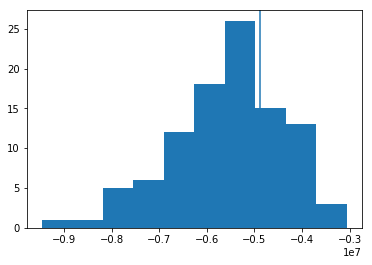

In [6]:
plt.hist(evals)
plt.axvline(ground_truth)

In [7]:
def pred(X_test):
    pY, pYv = m.predict_y(X_test)
    return pY, pYv
    
pY, pYv = pred(X_test)

In [8]:
m.X.batch_size

1000

In [9]:
st = time.time()
logt = []
logx = []
logf = []
rmse_hist = []
rmse_test_hist = []
def logger(x):
    print(m.compute_log_likelihood())
    logx.append(x)
    logf.append(m.compute_log_likelihood())
    logt.append(time.time() - st)
    py_train = m.predict_y(X_train)[0]
    py_test = m.predict_y(X_test)[0]
    rmse_hist.append(np.sqrt(np.mean((Y_train - py_train)**2)))
    rmse_test_hist.append(np.sqrt(np.mean((Y_test - py_test)**2)))
    logger.i+=1
logger.i = 1

In [10]:
m.feature.trainable = True
opt = gpflow.train.AdamOptimizer(learning_rate = 0.1)
m.compile()
opt.minimize(m, step_callback=logger, maxiter=2000)

-6598632.063322876
-4559242.879722712
-3918229.562256062
-3287673.1808373667
-4268269.139179012
-6015852.623222438
-2915316.4768125685
-5072483.532870921
-4489155.190433051
-2354833.263763496
-2981087.156160063
-2862303.6537768026
-2660733.444960178
-3687099.570814854
-3012019.400339464
-2506594.774998369
-2630016.934789204
-2785102.4402260203
-2018320.9428946455
-2463470.8280506125
-1741765.8005196701
-2359719.2635293277
-2120251.950900252
-1928867.7971599165
-1888054.6995461315
-1552103.4372418926
-1683832.9936170555
-2467840.5706205093
-2183472.974591788
-1325223.837508565
-2073760.4938268855
-2252527.5087103774
-1979932.4959831191
-1256666.379671969
-1982347.061917487
-2031202.0001461292
-1687285.5953944665
-1324811.3259728285
-1625521.424175527
-1496501.5749968279
-2172701.267784407
-1740668.829661294
-1607307.2142863397
-1647226.143788518
-1678189.1890476423
-1282711.7009035507
-1419410.5280408794
-1857135.3393257612
-1262655.7210517044
-1352312.2173855023
-1273115.056341747
-150

-428059.0953727675
-405964.84131557896
-543208.6630693872
-719459.4351619559
-488340.8900897473
-554474.6343079212
-666215.5082702466
-659948.3067412883
-300038.15413977474
-519931.0114750552
-489173.6259855402
-441449.9003631458
-482071.776661596
-562239.7271246281
-550840.7568399819
-434592.357352959
-505051.90880650317
-441565.71786485903
-497625.0265839124
-591108.8890449168
-721733.1723760541
-433998.8308051133
-463599.1438387729
-674636.6243838514
-463793.9931610408
-661214.1952479853
-483306.88408900006
-350468.9226317197
-464751.121791079
-564660.1079538591
-485525.2177279005
-437661.78116939863
-695537.8553836546
-449498.4566894238
-503342.73183925985
-718258.7561219832
-666715.165203829
-480890.21946407476
-576669.9450415438
-469442.80219220597
-492513.99176852
-564888.9400514452
-451431.16985491756
-554422.4981214639
-448622.68489472993
-502632.551930226
-660127.1330388518
-598377.7513103187
-377860.0980422895
-304255.1409496515
-691110.2529823835
-434185.26762540103
-534862

-358020.7137142224
-386612.71104526584
-471498.16774835665
-547384.009023404
-331750.51683615235
-355003.4338328382
-439340.96708179044
-325706.21472045116
-330963.08651003416
-414079.74061753805
-324811.92324883596
-337233.8305678108
-234643.6021742088
-302386.43953217723
-326438.1771485492
-439012.50457877084
-387872.242028566
-339333.7116783605
-403415.08185599354
-353896.884127851
-392887.79205993365
-333353.6274441035
-312743.70524100424
-401596.49620280904
-355782.10184467275
-423900.52761519566
-327458.21402112115
-337217.97662020446
-378838.13709027955
-383318.93502660043
-419496.72343954165
-342235.4020114745
-438470.4579810591
-348414.6750608786
-327411.0593839434
-424023.4674143719
-371506.21677185345
-336477.1931070304
-450352.2297764362
-402641.40712536493
-288452.820673477
-348516.92697875516
-264396.1373916944
-304802.23071718094
-525679.5656794894
-380457.2696882978
-395915.1764107199
-300360.8139686843
-318529.63277819543
-301893.7320941409
-417584.99607078184
-326303.

-244059.26906060326
-328743.5802328
-263372.67912232445
-259217.7406808684
-246298.56954465382
-305744.61902453896
-285947.21265704994
-338573.1172236372
-341297.8024449814
-244958.30091791836
-253644.69774437015
-296902.8129941944
-339298.9792204973
-225464.4668550471
-274468.80351720436
-308916.6515875938
-235723.042064557
-271932.4366824745
-411988.4113622602
-337855.9640981919
-266904.9185501736
-301434.97912012826
-351268.4830389365
-414312.5927462567
-309235.6898258198
-285267.2503390193
-426163.2339100898
-277135.033297905
-308808.912122526
-268243.7498782244
-314605.57820680534
-289973.83950043697
-271240.3346757306
-305391.1871146417
-221781.09529661998
-305632.53519795975
-293161.9428754441
-339422.8635087586
-283244.7662777161
-210590.78691611873
-336841.52548803453
-336645.7679652997
-290026.8330798078
-248989.8557065564
-428137.73221763753
-279077.040106594
-248610.42424870323
-392038.6402408286
-285685.6187375964
-248104.54417845642
-326613.6678120866
-322629.8907883509
-

-245830.33311504737
-255008.73728708623
-229507.79784708857
-229714.3381958796
-289466.2280482196
-288366.24066287617
-249382.68731822105
-271216.426428576
-237798.16505061553
-315932.25730552466
-215400.68786465196
-230774.59866824368
-242459.7220173915
-218841.95443163122
-176646.96702526655
-256721.7200212038
-261715.60448417463
-380792.0306622456
-240485.37317462586
-237943.00020160305
-245415.9318845255
-254074.35702024322
-215585.14484799295
-264052.0155434967
-221674.8259777045
-267924.40852208895
-311439.5485054742
-298481.3005965871
-288440.6005574875
-233434.98261741613
-198734.49343697366
-220073.78868100216
-222474.3890076087
-285587.03375703585
-258199.37031759776
-234161.08516533626
-215554.62558298503
-214434.25369542066
-249154.55722772106
-226118.2290210807
-254463.79211520017
-244368.41945895882
-181720.76048168138
-274699.9668927966
-285370.72994663485
-221567.60183814546
-260289.84042067663
-392608.02490921563
-257142.18428900026
-328159.17492209014
-212481.45144289

Text(0.5, 1.0, 'rmse of testing data vs iteration')

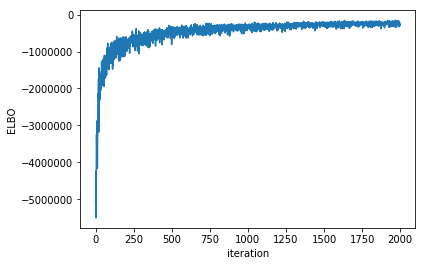

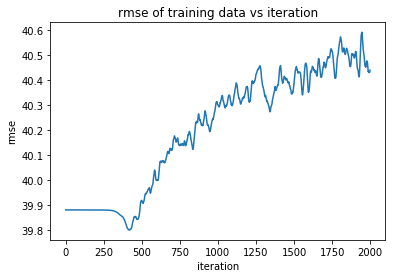

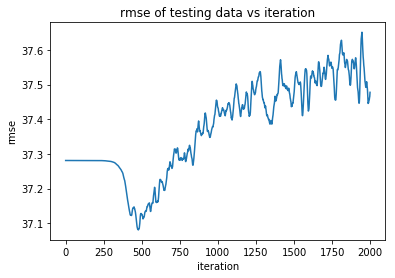

In [11]:
fig = plt.figure()
plt.plot(logf)
plt.xlabel('iteration')
plt.ylabel('ELBO')
fig = plt.figure()
plt.plot(rmse_hist)
plt.xlabel('iteration')
plt.ylabel('rmse')
plt.title("rmse of training data vs iteration")
fig = plt.figure()
plt.plot(rmse_test_hist)
plt.xlabel('iteration')
plt.ylabel('rmse')
plt.title("rmse of testing data vs iteration")

In [12]:
print(m.compute_log_likelihood())
print(logf[:10], rmse_hist[:10], rmse_test_hist[:10])
print(logf[-10:], rmse_hist[-10:], rmse_test_hist[-10:])



-226141.75233571717
[-223189.32583293482, -247161.88832378684, -183951.3817746763, -328720.58431149827, -234582.0475927102, -198104.1235196618, -262252.7713298025, -250507.24590732105, -300690.49746536155, -291578.8172763778] [40.43249038752629, 40.43194414105843, 40.431358572570495, 40.429092089143744, 40.43001544365537, 40.4312145671384, 40.43155206636491, 40.43114266666826, 40.43414371067458, 40.43877351590437] [37.450804162416304, 37.45197377289619, 37.453287793546096, 37.45429897096283, 37.45680885946893, 37.460618682282266, 37.463402956448355, 37.46516083006003, 37.469861822250394, 37.47783151263328]
[-5118694.505746136, -4235810.585484248, -5504076.484950087, -5066507.964834535, -4703785.721496718, -3350532.556987345, -3234048.803028493, -3528789.0535369706, -4159736.237293908, -3447608.2749365848] [39.88034947989621, 39.88035622824331, 39.88035365671979, 39.88035682922191, 39.88035889524194, 39.880356989816036, 39.88035743571023, 39.88035270388086, 39.88034693540815, 39.8803428

In [13]:
pY, pYv = m.predict_y(X_test)
rmse = np.sqrt(np.mean((Y_test - pY)**2))
print(rmse)
vY, vYv = m.predict_y(X_train)
rmse = np.sqrt(np.mean((Y_train - vY)**2))
print(rmse)

37.47783151263328
40.43877351590437


In [14]:
Y_train[:10]

array([  3.,  16.,   1.,  -7., -14.,  21.,   4., -13., 120.,  -7.])

In [15]:
vY[:10]

array([[-4.30808219],
       [ 6.00078441],
       [12.13867616],
       [ 3.00710993],
       [ 6.28831846],
       [ 6.88079994],
       [ 1.95510627],
       [ 9.10103294],
       [23.7609204 ],
       [ 3.55482803]])

In [16]:
m

,class,prior,transform,trainable,shape,fixed_shape,value
SVGP/feature/Z,Parameter,None,(none),False,"(100, 8)",True,"[[1.0, 19.0, 6.0, 558.0, 850.0, 90.0, 651.0, 7..."
SVGP/kern/lengthscales,Parameter,None,+ve,True,"(8,)",True,"[51.130260738165504, 99.05385455812545, 114.15..."
SVGP/kern/variance,Parameter,None,+ve,True,(),True,15.94411992281005
SVGP/likelihood/variance,Parameter,None,+ve,True,(),True,23.681537384817272
SVGP/q_mu,Parameter,None,(none),True,"(100, 1)",True,"[[-1.0789064025358688], [1.502822556831766], [..."
SVGP/q_sqrt,Parameter,None,LoTri->vec,True,"(1, 100, 100)",True,"[[[0.2006430853774972, 0.0, 0.0, 0.0, 0.0, 0.0..."
